# Importing Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import pathlib
import cv2
from tensorflow.keras import layers
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import csv
import numpy as np
import joblib

# Preparing dataset

In [2]:
#path_data = '../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'
path_test = '../Dataset/Brain-tumor/Testing/'
path_data = '../Dataset/Brain-tumor/Training/'


path_test = pathlib.Path(path_test)
path_data = pathlib.Path(path_data)
print(path_data)

image_count = len(list(path_data.glob('*/*.jpg')))
print(image_count)

..\Dataset\Brain-tumor\Training
5712


#### Image of a brain with tumor

### Creating Testing Validation and Testing Sets

In [3]:
batch = 32
img_height = 180
img_width = 180

In [4]:
train = tf.keras.preprocessing.image_dataset_from_directory(
path_data,
validation_split = 0.2,
subset = 'training',
seed = 42,
image_size  =(img_height,img_width),
batch_size = batch)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [5]:
val = tf.keras.preprocessing.image_dataset_from_directory(
path_data,
validation_split = 0.2,
subset = 'validation',
seed = 42,
image_size = (img_height,img_width),
batch_size = batch)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [6]:
test = tf.keras.preprocessing.image_dataset_from_directory(
path_test,
seed = 42,
image_size = (img_height,img_width),
batch_size = batch)

Found 1311 files belonging to 4 classes.


In [7]:
print(train.class_names)
print(val.class_names)
print(test.class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']
['glioma', 'meningioma', 'notumor', 'pituitary']
['glioma', 'meningioma', 'notumor', 'pituitary']


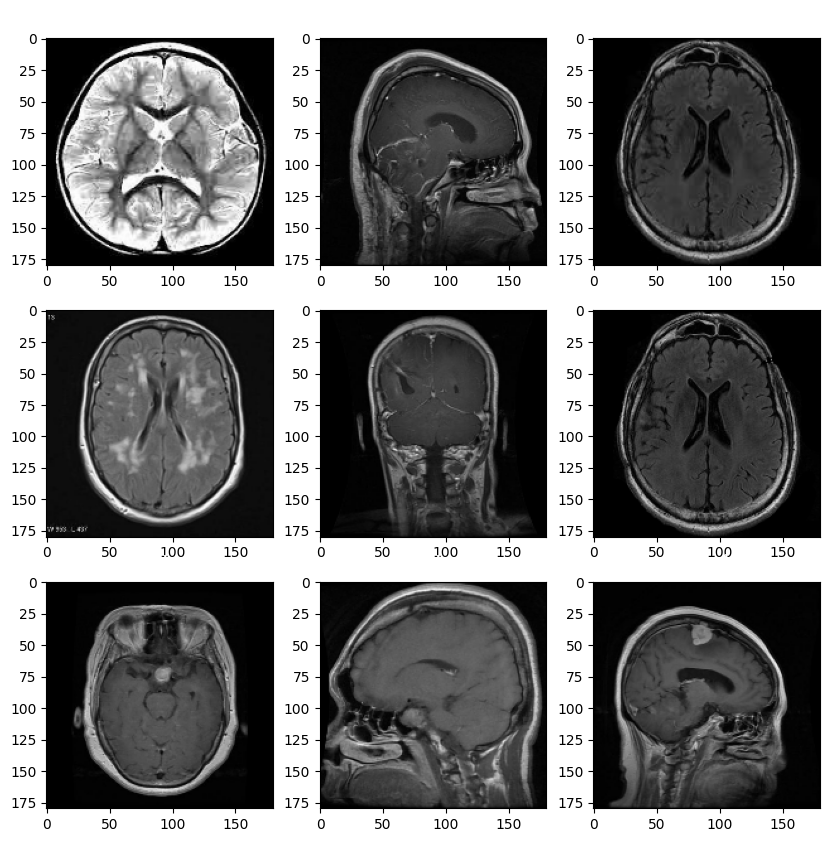

In [8]:
classes = train.class_names
plt.figure(figsize = (10,10))
for img,label in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(classes[label[i]],
                  fontdict = {'fontsize': '19',
                              'color': 'white'}
                 )
        

In [9]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.prefetch(buffer_size=AUTOTUNE)
val = val.prefetch(buffer_size=AUTOTUNE)
test = test.prefetch(buffer_size=AUTOTUNE)

# Helper Functions
<a id='helper'></a>

In [11]:
def test_tumor(list_test_path,model):
    for path_name in list_test_path:
        test_img_path = path_name


        test_image = tf.keras.preprocessing.image.load_img(
            test_img_path, target_size=(img_height, img_width)
        )
        test_array = tf.keras.preprocessing.image.img_to_array(test_image)
        test_array = tf.expand_dims(test_array, 0) # Create a batch

        predictions = model.predict(test_array)
        score = tf.nn.softmax(predictions[0])

        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(classes[np.argmax(score)], 100 * np.max(score))
        )

In [12]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
conv_layer_32 = tf.keras.layers.Conv2D(32,(3,3),activation='relu')
conv_layer_64 = tf.keras.layers.Conv2D(64,3,activation='relu')
conv_layer_16 = tf.keras.layers.Conv2D(16,3,activation='relu')
max_pool = tf.keras.layers.MaxPooling2D()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'experimental'

In [18]:
data_augmentation = tf.keras.Sequential(
  [
    normalization_layer,
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
    #tf.keras.layers.experimental.preprocessing.RandomCrop(170,170)  
  ]
)

# Model Building

In [20]:
num_classes = 4

model = tf.keras.Sequential([
  normalization_layer,
  conv_layer_32,
  max_pool,
  conv_layer_32,
  max_pool,
  conv_layer_32,
  max_pool,
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [21]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [22]:
history = model.fit(
    train,
    validation_data=val,
    epochs= 3,
    callbacks = callback,
    shuffle=False
)
eff_epochs = len(history.history['loss'])

Epoch 1/3


143/143 [==============================] - 77s 525ms/step - loss: 1.6527 - accuracy: 0.6884 - val_loss: 0.3734 - val_accuracy: 0.8774
Epoch 2/3
143/143 [==============================] - 71s 495ms/step - loss: 0.2572 - accuracy: 0.9155 - val_loss: 0.3022 - val_accuracy: 0.8967
Epoch 3/3
143/143 [==============================] - 71s 494ms/step - loss: 0.0944 - accuracy: 0.9737 - val_loss: 0.2940 - val_accuracy: 0.9037


In [58]:
joblib.dump(model, '../Models/bt-cnn.joblib')

['../Models/bt-cnn.joblib']

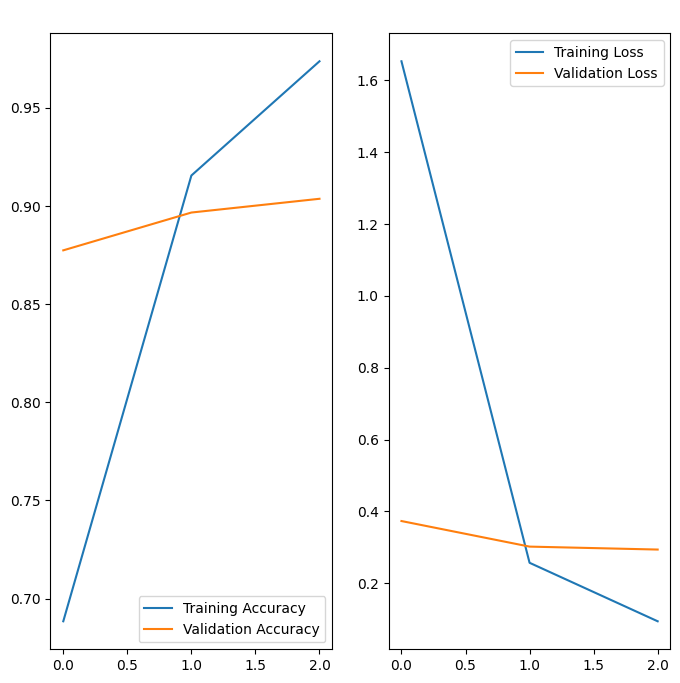

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 10

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(eff_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'white'})

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'white'})
plt.show()

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 253472)            0         
                                                                 
 dense (Dense)               (None, 128)               32444544  
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                      

In [25]:
results = model.evaluate(test)
print("test loss, test acc:", results)

41/41 [==============================] - 5s 104ms/step - loss: 0.2471 - accuracy: 0.9237
test loss, test acc: [0.24708357453346252, 0.9237223267555237]


In [30]:
list_of_paths = ['../Dataset/Brain-tumor/Testing/pituitary/Te-piTr_0007.jpg',
                '../Dataset/Brain-tumor/Testing/notumor/Te-noTr_0000.jpg',
                '../Dataset/Brain-tumor/Testing/meningioma/Te-meTr_0004.jpg',
                '../Dataset/Brain-tumor/Testing/glioma/Te-glTr_0007.jpg']
test_tumor(list_of_paths,model)

1/1 [==============================] - 0s 73ms/step
This image most likely belongs to pituitary with a 97.72 percent confidence.
1/1 [==============================] - 0s 53ms/step
This image most likely belongs to meningioma with a 83.58 percent confidence.
1/1 [==============================] - 0s 58ms/step
This image most likely belongs to meningioma with a 99.92 percent confidence.
1/1 [==============================] - 0s 48ms/step
This image most likely belongs to glioma with a 99.85 percent confidence.


# Second Model

Adding a data augmentation layer to add more images to the training data by simply modifying the existing images in ways such as flipping them or making similar random transformations to the training data.

In [31]:
num_classes = 4

model2 = tf.keras.Sequential([
  #data_augmentation,
  normalization_layer,
  #tf.keras.layers.Conv2D(32,3,activation='relu'),
  conv_layer_32,
  layers.MaxPooling2D(pool_size=(2,2)),
  conv_layer_32,
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes,activation='softmax')
])

In [32]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
epochs = 5
history = model2.fit(
  train,
  validation_data=val,
  epochs=epochs,
  callbacks = callback,
  shuffle=False
)

Epoch 1/5


143/143 [==============================] - 34s 235ms/step - loss: 0.4893 - accuracy: 0.8204 - val_loss: 0.3347 - val_accuracy: 0.8862
Epoch 2/5
143/143 [==============================] - 34s 240ms/step - loss: 0.2962 - accuracy: 0.8910 - val_loss: 0.3208 - val_accuracy: 0.8870
Epoch 3/5
143/143 [==============================] - 33s 230ms/step - loss: 0.2287 - accuracy: 0.9223 - val_loss: 0.2789 - val_accuracy: 0.9116
Epoch 4/5
143/143 [==============================] - 33s 231ms/step - loss: 0.1648 - accuracy: 0.9422 - val_loss: 0.2511 - val_accuracy: 0.9221
Epoch 5/5
143/143 [==============================] - 33s 230ms/step - loss: 0.1349 - accuracy: 0.9530 - val_loss: 0.2410 - val_accuracy: 0.9221


In [59]:
joblib.dump(model2, '../Models/bt-cnn2.joblib')

['../Models/bt-cnn2.joblib']

In [36]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 44, 44, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 61952)             0         
                                                                 
 dense_2 (Dense)             (None, 32)               

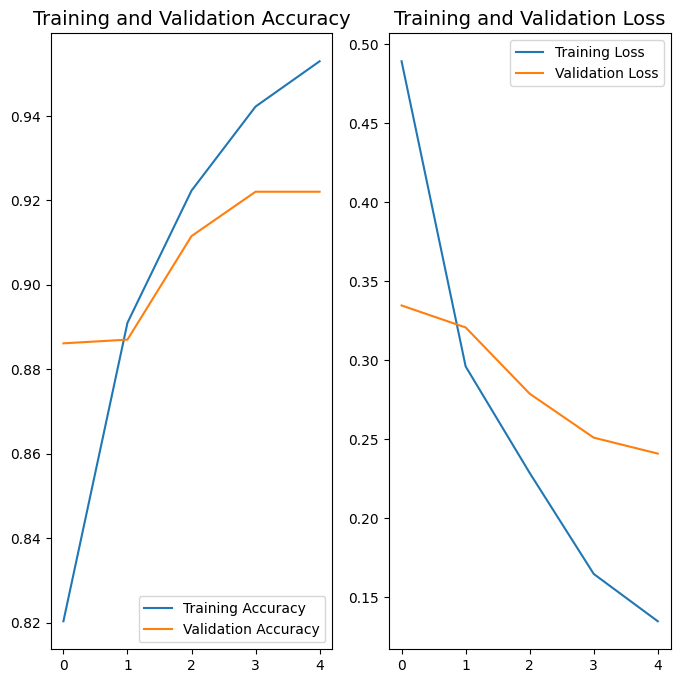

In [56]:
eff_epochs = len(history.history['loss'])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 10

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(eff_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'black'})

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'black'})
plt.show()

In [38]:
results = model2.evaluate(test)
print("test loss, test acc:", results)

41/41 [==============================] - 3s 65ms/step - loss: 0.2323 - accuracy: 0.9314
test loss, test acc: [0.23233157396316528, 0.9313501119613647]


## Third Model
### Using a pretrained model: MobileNetV2

In [39]:
# Create the base model from the pre-trained model MobileNet V2
image_size = (img_width,img_height)
IMG_SHAPE = image_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

9406464/9406464 [==============================] - 4s 0us/step


In [40]:
image_batch, label_batch = next(iter(train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [41]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 90, 90, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 90, 90, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 90, 90, 32)           0         ['bn_Conv1[

In [42]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [43]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [44]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [45]:
inputs = tf.keras.Input(shape=(180, 180, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1280,activation='relu')(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [46]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
len(model.trainable_variables)

4

In [50]:
initial_epochs = 5

loss0, accuracy0 = model.evaluate(val)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

36/36 [==============================] - 12s 338ms/step - loss: 0.2644 - accuracy: 0.9037
initial loss: 0.26
initial accuracy: 0.90


In [51]:
history_base = model.fit(train,
                         epochs=initial_epochs,
                         validation_data=val,
                         shuffle=False
                        )

Epoch 1/5


143/143 [==============================] - 59s 415ms/step - loss: 0.2706 - accuracy: 0.9004 - val_loss: 0.2557 - val_accuracy: 0.8993
Epoch 2/5
143/143 [==============================] - 63s 438ms/step - loss: 0.2100 - accuracy: 0.9232 - val_loss: 0.2311 - val_accuracy: 0.9098
Epoch 3/5
143/143 [==============================] - 65s 449ms/step - loss: 0.1768 - accuracy: 0.9278 - val_loss: 0.2582 - val_accuracy: 0.9124
Epoch 4/5
143/143 [==============================] - 55s 385ms/step - loss: 0.1503 - accuracy: 0.9438 - val_loss: 0.2014 - val_accuracy: 0.9291
Epoch 5/5
143/143 [==============================] - 57s 396ms/step - loss: 0.1281 - accuracy: 0.9479 - val_loss: 0.2442 - val_accuracy: 0.9247


In [60]:
joblib.dump(model, '../Models/bt-mobilenet.joblib')

['../Models/bt-mobilenet.joblib']

In [52]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 180, 180, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 180, 180, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

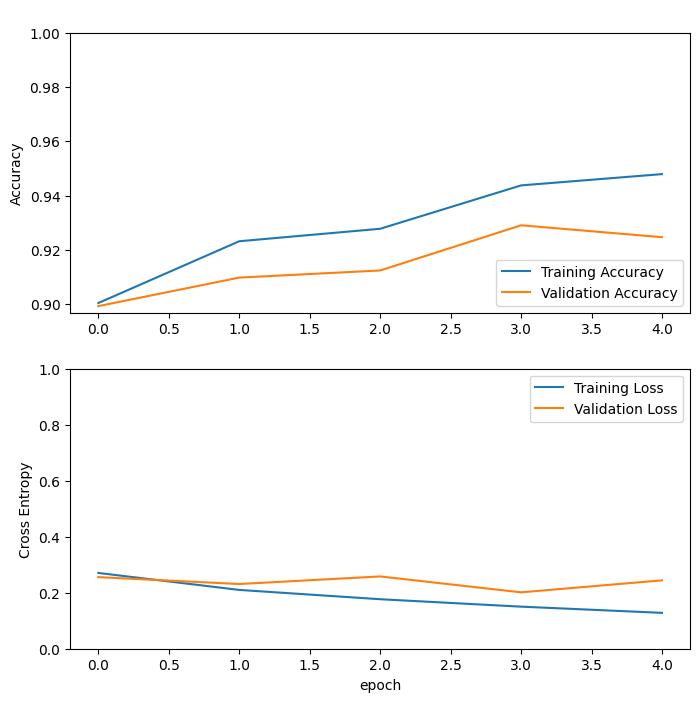

In [53]:
acc = history_base.history['accuracy']
val_acc = history_base.history['val_accuracy']

loss = history_base.history['loss']
val_loss = history_base.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'white'})

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')


plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'white'})
plt.xlabel('epoch')
plt.show()

In [54]:
result = model.evaluate(test)
print(result)

41/41 [==============================] - 15s 351ms/step - loss: 0.2543 - accuracy: 0.9222
[0.2542831003665924, 0.9221968054771423]
